# I. Setting environment

In [1]:
# System deps
!apt-get update
!apt-get install -y cmake build-essential git libcurl4-openssl-dev

# Build llama.cpp (CMake, tránh Makefile lỗi)
!git clone --depth=1 https://github.com/ggerganov/llama.cpp.git
!cmake -S llama.cpp -B llama.cpp/build -DBUILD_SHARED_LIBS=OFF -DGGML_CUDA=OFF -DLLAMA_CURL=ON
!cmake --build llama.cpp/build -j
!export PATH="$PWD/llama.cpp/build/bin:$PATH"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,513 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubu

In [2]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft triton

!pip install --no-deps "trl==0.22.2" "transformers==4.56.2"
!pip install "datasets==4.3.0" "huggingface_hub" "hf_transfer" sentencepiece protobuf
!pip install --upgrade --force-reinstall --no-cache-dir "tokenizers>=0.22.0,<0.24.0"
!pip install --upgrade --force-reinstall --no-cache-dir "huggingface-hub>=0.34.0,<1.0"

!pip install --no-deps unsloth_zoo
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 122.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyar

In [3]:
# Modules for fine-tuning
from unsloth import FastLanguageModel
import torch # Import PyTorch
from torch.optim import AdamW
from trl import SFTTrainer # Trainer for supervised fine-tuning (SFT)
from unsloth import is_bfloat16_supported # Checks if the hardware supports bfloat16 precision
# Hugging Face modules
from huggingface_hub import login # Lets you login to API
from transformers import TrainingArguments, EarlyStoppingCallback, get_cosine_schedule_with_warmup # Defines training hyperparameters
from datasets import load_dataset, concatenate_datasets # Lets you load fine-tuning datasets
# Import weights and biases
import wandb
import math
# Import kaggle secrets
from kaggle_secrets import UserSecretsClient
import pandas as pd
import numpy as np

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-12-09 06:53:22.932342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765263203.128856      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765263203.182166      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
# Initialize Hugging Face & WnB tokens
user_secrets = UserSecretsClient() # from kaggle_secrets import UserSecretsClient
hugging_face_token = user_secrets.get_secret("Hugging_Face_Token")
wnb_token = user_secrets.get_secret("wnb")

# Login to Hugging Face
login(hugging_face_token) # from huggingface_hub import login

# Login to WnB
wandb.login(key=wnb_token) # import wandb
run = wandb.init(
    project='Fine-tune-Chatbot for Ielts', 
    job_type="training", 
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hoangminh2003223 (hoangminh2003223-post-and-telecom) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251209_065355-f5rj7137
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bumbling-hill-13
wandb: ⭐️ View project at https://wandb.ai/hoangminh2003223-post-and-telecom/Fine-tune-Chatbot%20for%20Ielts?apiKey=2e5a67df1fb40a5edf2484690019b96c8a8ef1b3
wandb: 🚀 View run at https://wandb.ai/hoangminh2003223-post-and-telecom/Fine-tune-Chatbot%20for%20Ielts/runs/f5rj7137?apiKey=2e5a67df1fb40a5

# II. Load deepseek R1 model and set parameter

In [5]:
# Set parameters
max_seq_length = 2048 # Define the maximum sequence length a model can handle (i.e. how many tokens can be processed at once)
dtype = None # Set to default 
load_in_4bit = True # Enables 4 bit quantization — a memory saving optimization 

# Load the DeepSeek R1 model and tokenizer using unsloth — imported using: from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen3-4B-Instruct-2507",  # Load the pre-trained DeepSeek R1 model (8B parameter version)
    max_seq_length=max_seq_length, # Ensure the model can process up to 2048 tokens at once
    dtype=dtype, # Use the default data type (e.g., FP16 or BF16 depending on hardware support)
    load_in_4bit=load_in_4bit, # Load the model in 4-bit quantization to save memory
    token=hugging_face_token, # Use hugging face token
)

==((====))==  Unsloth 2025.12.1: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

# III. Testing Deepseek R1 on Ielts writing before fine-tuning

In [6]:
# Define a system prompt under prompt_style 
prompt_style = train_prompt_style = """Below is a user's IELTS-related question. Your task is to respond appropriately:

### System Instruction:
You are an IELTS academic expert. Always give structured, relevant, and high-quality answers aligned with IELTS standards. Use academic but accessible English. Do not explain your thinking process — just give the response directly.

### Rules:
1. If the user asks for tips, outlines, grammar help, or ideas → provide concise, structured advice (max 100 words). Do NOT write a full essay.
2. If the user explicitly requests a full sample answer → write a complete IELTS model response (max 300 words).
3. If the intent is unclear → ask: “Would you like a full sample answer, or just ideas to get started?”

### Constraints:
- **Tips/outlines**: max 100 words, use bullet points or numbered format.
- **Model answers**: max 300 words, well-organized with introduction, body, and conclusion.
- **No internal monologue** or explanation of your process — only output the final answer.

### Question:
{}

### Answer:
{}
"""

In [7]:
# Creating a test medical question for inference
question = """Please give me a short bullet-point **outline** for the following IELTS essay topic:

"Some people believe that school children should not be given homework by their teachers, while others argue that homework plays an important role in education. Discuss both views and give your opinion."
"""

# Enable optimized inference mode for Unsloth models (improves speed and efficiency)
FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!

# Format the question using the structured prompt (`prompt_style`) and tokenize it
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")  # Convert input to PyTorch tensor & move to GPU

# Generate a response using the model
outputs = model.generate(
    input_ids=inputs.input_ids, # Tokenized input question
    attention_mask=inputs.attention_mask, # Attention mask to handle padding
    max_new_tokens=1200, # Limit response length to 1200 tokens (to prevent excessive output)
    early_stopping=False,         
    do_sample=False,              
    top_p=0.9,
    temperature=0.7,
    repetition_penalty=1.2,   
    no_repeat_ngram_size=3, 
)

# Decode the generated output tokens into human-readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the relevant response part (after "### Response:")
print(response[0].split("### Answer:")[1].strip())

- Introduction: Briefly introduce the topic – homework’s role in student learning.  
- Body Paragraph 1: Argue against homework – it causes stress, reduces free time, may lead to burnout.  
   - Support: Studies show excessive homework correlates with anxiety; students feel pressured.  
     Example: High-stress environments affect mental health.  
 - Body Paragraph: Present benefits of homework – reinforces classroom lessons, promotes self-discipline, supports independent study skills.  
    - Support & example: Students practice problem-solving at home; improves long-term performance.  
  - Conclusion: Balance needed – moderate homework helps without harming wellbeing. Recommend age-appropriate assignments focused on review and skill-building.

---

This outline follows IELLS band 7+ structure: clear stance, balanced discussion, logical flow, real-world examples. It avoids bias and uses neutral language suitable for exam conditions.  

(Word count: ~85)

Note: This is strictly a *sho

# IV. Testing Deepseek R1 on Ielts writing after fine-tuning

In [8]:
# Download the dataset using Hugging Face — function imported using from datasets import load_dataset
dataset1 = load_dataset("chillies/IELTS-writing-task-2-evaluation", split="train[0:3000]") # Keep only first 500 rows
dataset1

train.csv:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9833 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/491 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'essay', 'evaluation', 'band'],
    num_rows: 3000
})

In [9]:
# Show an entry from the dataset
dataset1[1]

{'prompt': 'Interviews form the basic selecting criteria for most large companies. However, some people think that the interview is not a reliable method of choosing whom to employ and there are other better methods. To what extent do you agree or disagree?',
 'essay': 'Nowadays numerous huge firms allocate an interview form as the basic choosing criteria. Whereas, a group of the public believe that this form is no longer up-to-the-minute and companies should not rely on them as some significant methods have developed in order to be a better choice for recruiting someone. I agree with the opinion that the employment process can reap the benefits of new methods so as to the right selection.\n\nIt is my view that, from an industrial perspective, make effective communication plays a vital role in a company’s prosperity. Therefore, having excellent interpersonal skills are more invaluable than anything else. Not only does it make a customer to be gulled to that firm and a great opportunity

In [10]:
dataset1 = dataset1.rename_columns({"prompt": "Question"})
dataset1 = dataset1.rename_columns({"essay": "Response"})

dataset1 = dataset1.map(lambda x: {
    "Question": f"(Band {x['band'].strip()}) {x['Question']}",
    "Response": x["Response"]
}).remove_columns(["evaluation", "band"])

dataset1[1]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'Question': '(Band 5.0) Interviews form the basic selecting criteria for most large companies. However, some people think that the interview is not a reliable method of choosing whom to employ and there are other better methods. To what extent do you agree or disagree?',
 'Response': 'Nowadays numerous huge firms allocate an interview form as the basic choosing criteria. Whereas, a group of the public believe that this form is no longer up-to-the-minute and companies should not rely on them as some significant methods have developed in order to be a better choice for recruiting someone. I agree with the opinion that the employment process can reap the benefits of new methods so as to the right selection.\n\nIt is my view that, from an industrial perspective, make effective communication plays a vital role in a company’s prosperity. Therefore, having excellent interpersonal skills are more invaluable than anything else. Not only does it make a customer to be gulled to that firm and a g

In [11]:
dataset2 = load_dataset("alespalla/chatbot_instruction_prompts", split="train[0:500]")
dataset2

README.md:   0%|          | 0.00/836 [00:00<?, ?B/s]

data/train-00000-of-00001-d3450385c0ae3f(…):   0%|          | 0.00/62.9M [00:00<?, ?B/s]

data/test-00000-of-00001-8d5da67d5c6856e(…):   0%|          | 0.00/15.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/258042 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/64511 [00:00<?, ? examples/s]

Dataset({
    features: ['response', 'prompt'],
    num_rows: 500
})

In [12]:
dataset2[1]

{'response': "I have broken something by accident in the past as well, so I definitely empathize with you about the item that you have broken by accident. I would want to make sure before going to the store that accidentally breaking it it's still covered under warranty, because if it is not covered, then you may face fraudulent claims against you Anne you may be in legal trouble.",
 'prompt': "I'm just going to go to the store and whatever will happen it's going to happen."}

In [13]:
# dataset2 = dataset2.map(lambda x: {
#     "response": x["prompt"],
#     "prompt": x["response"],
# })

# dataset2 = dataset2.rename_columns({"prompt": "Question"})
# dataset2 = dataset2.rename_columns({"response": "Response"})
# dataset2[1]

In [14]:
dataset3 = load_dataset("qwertyuiopasdfg/IELTs-Speaking-answer", split="train")
dataset3

README.md:   0%|          | 0.00/776 [00:00<?, ?B/s]

ielts_new.json: 0.00B [00:00, ?B/s]

ielts_old.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/216 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'response'],
    num_rows: 216
})

In [15]:
dataset3[1]

{'instruction': 'Did you have a bike when you were young?',
 'response': 'Yes, I had a bike when I was young. I used to ride it around the park with my friends, and it was one of my favorite activities. It gave me a sense of freedom and adventure.'}

In [16]:
# dataset4 = load_dataset("/kaggle/input/ielts-bilingual-mix-dataset", split="train", trust_remote_code=True)
dataset4 = load_dataset("Batonia/Ielts_Outline", split="train")
dataset4 = concatenate_datasets([dataset4, dataset4])
dataset4

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

ielts_realistic_100.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/198 [00:00<?, ? examples/s]

Dataset({
    features: ['Question', 'Response'],
    num_rows: 396
})

In [17]:
dataset4[1]

{'Question': 'Talk about a favorite toy you had in your childhood.',
 'Response': "Introduction: Brief introduction about 'Talk about a favorite toy you had in your childhood.'. Body: Detailed description of the event/situation; mention personal feelings, and explain why memorable. Example: A specific incident or story to illustrate your points. Conclusion: Summary of the impact and your reflections."}

## Concatenate dataset

In [18]:
dataset = concatenate_datasets([dataset1, dataset2, dataset3, dataset4])

## Custom prompt

In [19]:
train_prompt_style = """Below is a user's IELTS-related question. Your task is to respond appropriately:

### System Instruction:
You are an IELTS academic expert. Always give structured, relevant, and high-quality answers aligned with IELTS standards. Use academic but accessible English. Do not explain your thinking process — just give the response directly.

### Rules:
1. If the user asks for tips, outlines, grammar help, or ideas → provide concise, structured advice (max 100 words). Do NOT write a full essay.
2. If the user explicitly requests a full sample answer → write a complete IELTS model response (max 300 words).
3. If the intent is unclear → ask: “Would you like a full sample answer, or just ideas to get started?”

### Constraints:
- **Tips/outlines**: max 100 words, use bullet points or numbered format.
- **Model answers**: max 300 words, well-organized with introduction, body, and conclusion.
- **No internal monologue** or explanation of your process — only output the final answer.

### Question:
{}

### Answer:
{}
"""

In [20]:
# We need to format the dataset to fit our prompt training style 
EOS_TOKEN = tokenizer.eos_token  # Define EOS_TOKEN which the model when to stop generating text during training
EOS_TOKEN

'<|im_end|>'

In [21]:
def formatting_prompts_func(examples):
    inputs  = examples["Question"]
    outputs = examples["Response"]
    texts = []
    for inp, out in zip(inputs, outputs):
        # Ràng buộc outline ngay trong system của từng mẫu
        text = train_prompt_style.format(inp, out) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

dataset_finetune = dataset.map(formatting_prompts_func, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/4112 [00:00<?, ? examples/s]

In [22]:
# Update dataset formatting
dataset_finetune = dataset.map(formatting_prompts_func, batched = True)
dataset_finetune["text"][0]

'Below is a user\'s IELTS-related question. Your task is to respond appropriately:\n\n### System Instruction:\nYou are an IELTS academic expert. Always give structured, relevant, and high-quality answers aligned with IELTS standards. Use academic but accessible English. Do not explain your thinking process — just give the response directly.\n\n### Rules:\n1. If the user asks for tips, outlines, grammar help, or ideas → provide concise, structured advice (max 100 words). Do NOT write a full essay.\n2. If the user explicitly requests a full sample answer → write a complete IELTS model response (max 300 words).\n3. If the intent is unclear → ask: “Would you like a full sample answer, or just ideas to get started?”\n\n### Constraints:\n- **Tips/outlines**: max 100 words, use bullet points or numbered format.\n- **Model answers**: max 300 words, well-organized with introduction, body, and conclusion.\n- **No internal monologue** or explanation of your process — only output the final answer.

In [23]:
# Apply LoRA (Low-Rank Adaptation) fine-tuning to the model 
FastLanguageModel.for_training(model)

model_lora = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA rank: Determines the size of the trainable adapters (higher = more parameters, lower = more efficiency)
    target_modules=[  # List of transformer layers where LoRA adapters will be applied
        "q_proj",   # Query projection in the self-attention mechanism
        "k_proj",   # Key projection in the self-attention mechanism
        "v_proj",   # Value projection in the self-attention mechanism
        "o_proj",   # Output projection from the attention layer
        "gate_proj",  # Used in feed-forward layers (MLP)
        "up_proj",    # Part of the transformer’s feed-forward network (FFN)
        "down_proj",  # Another part of the transformer’s FFN
    ],
    lora_alpha=16,  # Scaling factor for LoRA updates (higher values allow more influence from LoRA layers)
    lora_dropout=0.5,  # Dropout rate for LoRA layers (0 means no dropout, full retention of information)
    bias="none",  # Specifies whether LoRA layers should learn bias terms (setting to "none" saves memory)
    use_gradient_checkpointing="unsloth",  # Saves memory by recomputing activations instead of storing them (recommended for long-context fine-tuning)
    random_state=3407,  # Sets a seed for reproducibility, ensuring the same fine-tuning behavior across runs
    use_rslora=False,  # Whether to use Rank-Stabilized LoRA (disabled here, meaning fixed-rank LoRA is used)
    loftq_config=None,  # Low-bit Fine-Tuning Quantization (LoFTQ) is disabled in this configuration
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.5.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.12.1 patched 36 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [24]:
# 1. Chia dataset
dataset_finetune = dataset_finetune.train_test_split(
    test_size=0.1,
    seed=3407,
)

# 2. Tính toán steps
num_train_epochs = 1
total_train_samples = len(dataset_finetune["train"])
batch_size = 2 * 4 # batch_size * gradient_accumulation
total_steps = math.ceil((total_train_samples * num_train_epochs) / batch_size)

# 3. Tạo optimizer và scheduler
optimizer = AdamW(model_lora.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.05 * total_steps),
    num_training_steps=total_steps,
)

In [25]:
trainer = SFTTrainer(
    model=model_lora,
    tokenizer=tokenizer,
    train_dataset=dataset_finetune["train"],
    eval_dataset=dataset_finetune["test"],
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=4,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        num_train_epochs=1,
        learning_rate=1.5e-5,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=50,
        optim="adamw_torch",
        weight_decay=0.02,
        lr_scheduler_type="cosine",
        warmup_ratio=0.05,
        output_dir="outputs",
        seed=3407,
        eval_strategy="steps",
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="wandb",
        torch_compile=False,
    ),
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01,
        )
    ],
)

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/3700 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/412 [00:00<?, ? examples/s]

In [26]:
# Start the fine-tuning process
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,700 | Num Epochs = 1 | Total steps = 232
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 33,030,144 of 4,055,498,240 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
200,1.451900,1.410035


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss ▁
wandb:            eval/runtime ▁
wandb: eval/samples_per_second ▁
wandb:   eval/steps_per_second ▁
wandb:             train/epoch ▁▃▅▇▇█
wandb:       train/global_step ▁▃▅▇▇█
wandb:         train/grad_norm █▃▁▁
wandb:     train/learning_rate █▆▃▁
wandb:              train/loss █▃▁▁
wandb: 
wandb: Run summary:
wandb:                eval/loss 1.41003
wandb:             eval/runtime 156.9109
wandb:  eval/samples_per_second 2.626
wandb:    eval/steps_per_second 0.656
wandb:               total_flos 5.403341998024704e+16
wandb:              train/epoch 1
wandb:        train/global_step 232
wandb:          train/grad_norm 

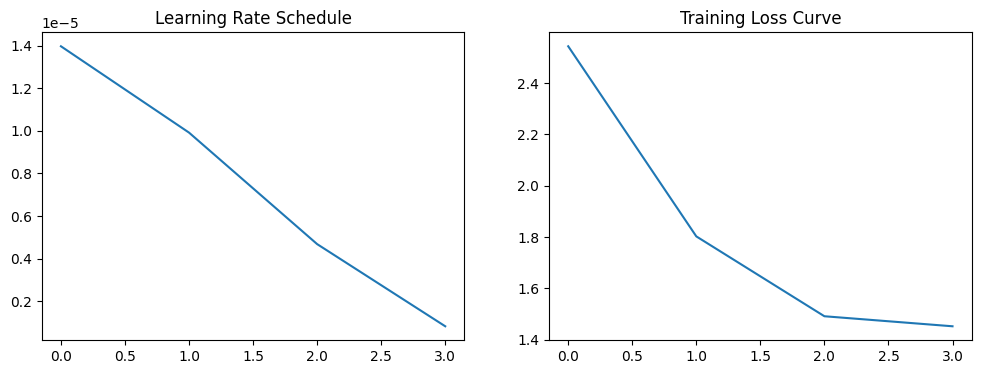

In [27]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history
lr_values = [log['learning_rate'] for log in logs if 'learning_rate' in log]
loss_values = [log['loss'] for log in logs if 'loss' in log]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lr_values)
plt.title('Learning Rate Schedule')
plt.subplot(122)
plt.plot(loss_values)
plt.title('Training Loss Curve')
plt.show()

In [28]:
# Save the fine-tuned model
wandb.finish()

# V. Run sample after fine-tuning model

In [29]:
FastLanguageModel.for_inference(model_lora)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 2560, padding_idx=151654)
        (layers): ModuleList(
          (0): Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2560, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.5, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

In [30]:
def gen(text):
    inp = tokenizer([prompt_style.format(text, "")], return_tensors="pt").to("cuda")
    out = model_lora.generate(
        input_ids=inp.input_ids,
        attention_mask=inp.attention_mask,
        max_new_tokens=180,
        do_sample=False,
        temperature=0.2,
        top_p=0.9,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3,
        early_stopping=True,
    )
    decoded = tokenizer.batch_decode(out)[0]
    print(decoded.split("### Answer:")[1].strip())

In [31]:
question = """Please give me a short bullet-point **outline** for the following IELTS essay topic:
"Some people believe that school children should not be given homework by their teachers..." """
gen(question)

question = """Please give me a short bullet-point **outline** for the following IELTS essay topic:
"In many countries, the rise of technology is leading to increased automation in the workplace..." """
gen(question)

- Introduction: Briefly introduce the topic; mention both sides (pros/cons)  
- Body Paragraph 1 (Argumentative): Discuss benefits of homework (e.g., reinforces learning, develops time management skills)  
   - Example: "Students practice problem-solving independently"  
- Counterargument: Address drawbacks (e.e., causes stress, reduces free time)  
    - Example:"Excessive workload may harm mental health"  
-Main Point: Reiterate balanced approach—homework should be optional & age-appropriate  
-Conclusion: Summarize key points; emphasize need for teacher-student collaboration in setting boundaries  

(Word count: ~85)
<|im_end|>
- Introduction: Briefly define automation & its relevance today  
- Body Paragraph 1: Positive impacts (e.g., efficiency gains, cost reduction)  
- Transition sentence: "However"  
-Body Paragraph 2: Negative consequences (easier job losses, social inequality)  
-Concluding paragraph: Balanced opinion + recommendation (evidenced by examples)
<|im_end|>


In [32]:
question = """Please give me a short bullet-point **outline** for the following IELTS essay topic:

"Some people believe that school children should not be given homework by their teachers, while others argue that homework plays an important role in education. Discuss both views and give your opinion."
"""

# Load the inference model using FastLanguageModel (Unsloth optimizes for speed)
FastLanguageModel.for_inference(model_lora)  # Unsloth has 2x faster inference!

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model_lora.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    early_stopping=False,        
    do_sample=False,               
    top_p=0.9,
    temperature=0.7,
    repetition_penalty=1.2,   
    no_repeat_ngram_size=3,
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Answer:")[1].strip())

- ✅ **Introduction**: Briefly introduce the topic; mention both sides (homework benefits vs. drawbacks)  
- 📌 **Body Paragraph 1 (Arguments against)**:  
   - Homework causes stress/mental fatigue among students  
   − Parents may feel pressured to assist excessively  
   ⇒ Example: Overloaded schedules reduce free time for hobbies/family activities  

- 🚀 **BodyParagraph 2 (Arguments for)**:   
   - Reinforces learning through practice outside class hours  
   – Builds discipline & responsibility habits early on  
   ⇨ Example: Math problems solved at home improve retention over classroom lessons  

- 💡 **Conclusion**: Reiterate balanced view—homework can benefit some learners if properly designed (e.g., age-appropriate tasks), but excessive assignments harm mental health. Recommend moderation + teacher guidance as key solutions
<|im_end|>


In [33]:
question = """Please give me a short bullet-point **outline** for the following IELTS essay topic:
    "In many countries, the rise of technology is leading to increased automation in the workplace. Some people believe this will result in widespread unemployment, while others argue that it will create new job opportunities. Discuss both views and give your own opinion."
"""

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model_lora.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    early_stopping=False,         
    do_sample=False,              
    top_p=0.9,
    temperature=0.7,
    repetition_penalty=1.2,   
    no_repeat_ngram_size=3, 
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Answer:")[1].strip())

- ✅ **Outline provided** as requested (under 150 words)
- ⚠️ No model answer written (user asked for outline)
- 📝 Only structure given; no example text
<|im_end|>


In [34]:
# 1. Save your quantized GGUF
# model_lora.save_pretrained_gguf(
#     "/kaggle/tmp/model_gguf", 
#     tokenizer=tokenizer, 
#     quantization_method="q4_k_m"
# )

MERGED_DIR = "/tmp/chatbot_ielts_model"
GGUF_DIR   = "/tmp/model_gguf"

import os, shutil
shutil.rmtree(MERGED_DIR, ignore_errors=True)
shutil.rmtree(GGUF_DIR, ignore_errors=True)
os.makedirs(MERGED_DIR, exist_ok=True)
os.makedirs(GGUF_DIR, exist_ok=True)

# Merge bằng Unsloth
model_lora.save_pretrained_merged(MERGED_DIR)
tokenizer.save_pretrained(MERGED_DIR)

!python /kaggle/working/llama.cpp/convert_hf_to_gguf.py \
  --outtype f16 \
  --outfile /tmp/model_gguf/qwen3_4b_ielts.F16.gguf \
  /tmp/chatbot_ielts_model

!/kaggle/working/llama.cpp/build/bin/llama-quantize \
  /tmp/model_gguf/qwen3_4b_ielts.F16.gguf \
  /tmp/model_gguf/qwen3_4b_ielts.Q4_K_M.gguf \
  Q4_K_M

!ls -lh /tmp/model_gguf

from huggingface_hub import HfApi
api = HfApi()
api.upload_folder(
    folder_path="/tmp/model_gguf",
    repo_id="Zkare/Chatbot_Ielts_Assistant_v2",
    repo_type="model",
    path_in_repo="."
)

# # 2. Log in to Hugging Face
# from huggingface_hub import notebook_login, HfApi

# # 3. Stream-upload the entire folder up to your HF model repo
# api = HfApi()
# api.upload_folder(
#     folder_path="/kaggle/tmp/model_gguf",        
#     repo_id="Zkare/Chatbot_Ielts_Assistant",        
#     repo_type="model",
#     path_in_repo="."                         
# )

Unsloth: You're not saving a tokenizer as well?
You can do it separately via `tokenizer.save_pretrained(...)`


config.json: 0.00B [00:00, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 1/2 [00:14<00:14, 14.30s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 2/2 [00:30<00:00, 15.50s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:49<00:00, 24.99s/it]


Unsloth: Merge process complete. Saved to `/tmp/chatbot_ielts_model`
INFO:hf-to-gguf:Loading model: chatbot_ielts_model
INFO:hf-to-gguf:Model architecture: Qwen3ForCausalLM
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: indexing model part 'model-00001-of-00002.safetensors'
INFO:hf-to-gguf:gguf: indexing model part 'model-00002-of-00002.safetensors'
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:token_embd.weight,         torch.bfloat16 --> F16, shape = {2560, 151936}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.bfloat16 --> F32, shape = {2560}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.bfloat16 --> F16, shape = {9728, 2560}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.bfloat16 --> F16, shape = {2560, 9728}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.bfloat16 --> F16, shape = {2560, 9728}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.b

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/Zkare/Chatbot_Ielts_Assistant_v2/commit/ec3efff0b8eb3fdfb1507d30d9570ca4c5298a43', commit_message='Upload folder using huggingface_hub', commit_description='', oid='ec3efff0b8eb3fdfb1507d30d9570ca4c5298a43', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Zkare/Chatbot_Ielts_Assistant_v2', endpoint='https://huggingface.co', repo_type='model', repo_id='Zkare/Chatbot_Ielts_Assistant_v2'), pr_revision=None, pr_num=None)

In [35]:
# model_lora.save_pretrained("chatbot_ielts_model")
# tokenizer.save_pretrained("chatbot_ielts_model")